# Samadhi Model: Time Series Anomaly Detection (New Framework)

このノートブックは、リファクタリングされた **Samadhi Framework** を使用して、時系列センサーデータに対する **異常検知** を実行する方法を示します。

## Key Concepts

異常検知プロセスは、以下の2つのフェーズに分かれています。

1.  **Phase 1: Autoencoder Pre-training**
    * **Objective:** \`AutoencoderObjective\`
    * **Goal:** 複雑な認知モジュール (Vitakka/Vicara) を使用せず、モデルに正常な時系列パターンを再構築することを学習させます。これにより、「潜在空間マップ」が構築されます。

2.  **Probe Initialization (Interim Step)**
    * **Goal:** 事前学習された正常データに対してK-Meansクラスタリングを使用し、潜在空間内の「正常の中心」（Probes）を特定します。

3.  **Phase 2: Main Training (Purification & Contrastive Learning)**
    * **Objective:** \`AnomalyObjective\` (New!)
    * **Goal:**
        * **Attract Normal Data:** 再構築誤差を最小化し、思考プロセスを安定化させます（プローブへの収束）。
        * **Repel Anomaly Data:** **Margin Loss** (コントラスト学習) を使用して再構築誤差を最大化します。

## Workflow

1.  **Data Loading & Preprocessing:** センサーデータをロードし、時系列シーケンスを作成します。
2.  **Model Instantiation:** \`create_lstm_samadhi\` ファクトリを使用します。
3.  **Phase 1 Training:** 純粋なAutoencoderとして学習させます。
4.  **Probe Initialization:** 正常データの潜在ベクトルをクラスタリングします。
5.  **Phase 2 Training:** \`AnomalyObjective\` を使用して異常識別のため学習させます。
6.  **Evaluation:** 再構築誤差と収束の安定性を分析して異常を検出します。


In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
import warnings

warnings.filterwarnings("ignore")

# --- Samadhi Framework Imports ---
from src.configs.main import SamadhiConfig
from src.presets.sequence import create_lstm_samadhi
from src.train.hf_trainer import SamadhiTrainer
from src.train.objectives.autoencoder import AutoencoderObjective
from src.train.objectives.anomaly import AnomalyObjective

print(f"Torch device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")


Torch device: cpu


## Configuration

モデルと学習プロセスのハイパーパラメータを定義します。\`SamadhiConfig\` オブジェクトがこれらの設定を階層的に管理します。


In [2]:
LATENT_DIM = 32
SEQ_LEN = 30
N_PROBES = 10
BATCH_SIZE = 256

# Configuration Dictionary
config_dict = {
    "dim": LATENT_DIM,
    "seed": 42,
    # --- Component Configs ---
    "adapter": {
        "type": "lstm",
        "input_dim": None,  # Will be set after data loading
        "hidden_dim": 128,
        "num_layers": 2,
        "seq_len": SEQ_LEN,
    },
    "vitakka": {
        "n_probes": N_PROBES,
        "attention_mode": "soft", # Soft attention for training gradient flow
    },
    "vicara": {
        "refine_steps": 5,
        "gate_threshold": 0.5,
    },
    "decoder": {
        "type": "lstm",
        "hidden_dim": 128,
        "num_layers": 2,
        "seq_len": SEQ_LEN,
    },
    "objective": {
        "stability_coeff": 0.1,
        "entropy_coeff": 0.05,
        "balance_coeff": 1.0,
        "anomaly_margin": 2.0,  # Margin for anomaly loss
        "anomaly_weight": 1.0,  # Weight for anomaly penalty
    }
}


## Data Loading & Preparation

\`sensor.csv\` データセットをロードし、前処理を行い、学習セットとテストセットに分割します。また、Hugging Face Trainerと連携するためのカスタム \`TorchDataset\` を定義します。


In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        item = {"x": self.X[idx]} # Key 'x' matches SamadhiEngine forward signature
        if self.y is not None:
            item["y"] = self.y[idx] # Key 'y' passed to Objective
        return item

def create_sequences(data, seq_len):
    xs = []
    for i in range(len(data) - seq_len + 1):
        xs.append(data[i : (i + seq_len)])
    return np.array(xs)

def load_and_preprocess_data(path, seq_len):
    print(f"Loading data from {path}...")
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        df = pd.read_csv("../" + path)

    # Label Encoding
    if 'machine_status' in df.columns:
        df['label'] = df['machine_status'].apply(lambda x: 0 if x == 'NORMAL' else 1)
        labels = df['label'].values
    else:
        labels = np.zeros(len(df))

    # Drop columns
    cols_to_drop = ['Unnamed: 0', 'timestamp', 'machine_status', 'label', 'Class', 'sensor_15']
    features_df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')
    features_df = features_df.fillna(method='ffill').fillna(0)

    # Select numeric
    numeric_cols = features_df.select_dtypes(include=np.number).columns.tolist()
    features_df = features_df[numeric_cols]

    # Scale
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)

    # Create sequences
    sequences = create_sequences(scaled_features, seq_len)
    sequence_labels = labels[seq_len - 1 :]

    # Split (Time-based)
    split_train = 110000
    split_test = 150000

    X_train = sequences[:split_train]
    y_train = sequence_labels[:split_train]

    X_test = sequences[split_train:split_test]
    y_test = sequence_labels[split_train:split_test]

    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    return X_train, y_train, X_test, y_test, sequences.shape[-1]

# Load Data
DATA_PATH = "data/sensor.csv"
X_train, y_train, X_test, y_test, input_dim = load_and_preprocess_data(DATA_PATH, SEQ_LEN)

# Update Config
config_dict["adapter"]["input_dim"] = input_dim
config_dict["decoder"]["output_dim"] = input_dim
config = SamadhiConfig.from_dict(config_dict)
print(f"Config Input Dim set to: {config.adapter.input_dim}")

# Create Datasets
train_dataset_full = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# For Pre-training (Normal Data Only)
X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]
train_dataset_normal = TimeSeriesDataset(X_train_normal, y_train_normal)

print(f"Pre-train dataset size (Normal only): {len(train_dataset_normal)}")


Loading data from data/sensor.csv...
Train: (110000, 30, 51), Test: (40000, 30, 51)
Config Input Dim set to: 51
Pre-train dataset size (Normal only): 104025


## Model Instantiation

\`create_lstm_samadhi\` ファクトリを使用してモデルを作成します。これは、LSTM AdapterとDecoderで構成された \`SamadhiEngine\` を構築します。


In [4]:
model = create_lstm_samadhi(config)
print(model)


SamadhiEngine(
  (adapter): LstmAdapter(
    (lstm): LSTM(51, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=32, bias=True)
    (activation): Tanh()
  )
  (vitakka): StandardVitakka()
  (vicara): StandardVicara(
    (refiners): ModuleList(
      (0): MlpRefiner(
        (net): Sequential(
          (0): Linear(in_features=32, out_features=16, bias=True)
          (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (2): ReLU()
          (3): Linear(in_features=16, out_features=32, bias=True)
          (4): Tanh()
        )
      )
    )
  )
  (decoder): LstmDecoder(
    (fc_start): Linear(in_features=32, out_features=128, bias=True)
    (lstm): LSTM(128, 128, batch_first=True)
    (fc_out): Linear(in_features=128, out_features=51, bias=True)
  )
)


## Phase 1: Autoencoder Pre-training

\`AutoencoderObjective\` を使用してモデルを学習させます。これにより、VitakkaとVicaraは無効化され、AdapterとDecoderのみが入力の再構築のために学習されます。ここでは **正常な** データのみを使用します。


In [5]:
from transformers import TrainingArguments

# 1. Define Objective
ae_objective = AutoencoderObjective(config)

# 2. Training Args
args_phase1 = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    logging_steps=500,
    remove_unused_columns=False, # Essential for custom datasets
    report_to="none"
    )

# 3. Trainer
trainer_phase1 = SamadhiTrainer(
    model=model,
    args=args_phase1,
    train_dataset=train_dataset_normal,
    objective=ae_objective
    )

# 4. Train
trainer_phase1.train()


Step,Training Loss
500,0.159400
1000,0.066500
1500,0.052600
2000,0.046600


TrainOutput(global_step=2035, training_loss=0.08063970063183759, metrics={'train_runtime': 47.6818, 'train_samples_per_second': 10908.256, 'train_steps_per_second': 42.679, 'total_flos': 0.0, 'train_loss': 0.08063970063183759, 'epoch': 5.0})

## Probe Initialization

Adapterが意味のある潜在ベクトルを生成できるようになったので、この潜在空間内の正常な学習データをクラスタリングして、Probesを初期化します。


In [6]:
def initialize_probes(model, dataset, n_probes, device):
    print("Initializing probes via KMeans...")
    model.eval()
    model.to(device)

    # 1. Collect Latents
    latents = []
    loader = DataLoader(dataset, batch_size=512, shuffle=False)

    with torch.no_grad():
        for batch in loader:
            x = batch["x"].to(device)
            # Only run adapter
            z = model.adapter(x)
            latents.append(z.cpu().numpy())

    latents = np.concatenate(latents, axis=0)

    # Subsample if too large
    if len(latents) > 20000:
        indices = np.random.choice(len(latents), 20000, replace=False)
        latents_sub = latents[indices]
    else:
        latents_sub = latents

    # 2. KMeans
    kmeans = KMeans(n_clusters=n_probes, random_state=42, n_init='auto')
    kmeans.fit(latents_sub)
    centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

    # 3. Set Probes
    model.vitakka.probes.data = centroids
    print("Probes initialized successfully.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initialize_probes(model, train_dataset_normal, N_PROBES, device)


Initializing probes via KMeans...
Probes initialized successfully.


## Phase 2: Main Training (Anomaly Objective)

ここで \`AnomalyObjective\` に切り替えます。これにより、フルモデル（Vitakka探索 + Vicara洗練）が学習されます。

* **Normal Data:** プローブに収束するように学習されます（再構築誤差の最小化）。
* **Anomaly Data:** 「拒否」されるように学習されます（再構築誤差 > マージンの最大化）。

このフェーズでは、異常を含むフル学習セットを使用します。


In [ ]:
# 1. Define Anomaly Objective
anomaly_objective = AnomalyObjective(config)

# 2. Training Args
args_phase2 = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=5e-4, # Slightly lower LR for fine-tuning
    logging_steps=500,
    remove_unused_columns=False,
    )

# 3. Trainer
trainer_phase2 = SamadhiTrainer(
    model=model,
    args=args_phase2,
    train_dataset=train_dataset_full, # Use full dataset with anomalies
    objective=anomaly_objective
    )

# 4. Train
trainer_phase2.train()

Step,Training Loss
500,0.156400
1000,0.085600
1500,0.074900
2000,0.068000


TrainOutput(global_step=2150, training_loss=0.09411568220271621, metrics={'train_runtime': 95.6342, 'train_samples_per_second': 5751.083, 'train_steps_per_second': 22.482, 'total_flos': 0.0, 'train_loss': 0.09411568220271621, 'epoch': 5.0})

## Evaluation & Analysis

テストセットでモデルを評価します。以下の点に着目します。
1.  **Reconstruction Error:** 正常データでは低く、異常データでは高くなるはずです。
2.  **ROC-AUC:** 全体的な検出性能です。
3.  **Visualizations:** 誤差の分布と散布図です。


Evaluating...
ROC-AUC Score: 0.9967
Best Threshold (Max F1): 2.9627
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     31567
       Fraud       0.96      0.99      0.97      8433

    accuracy                           0.99     40000
   macro avg       0.98      0.99      0.98     40000
weighted avg       0.99      0.99      0.99     40000



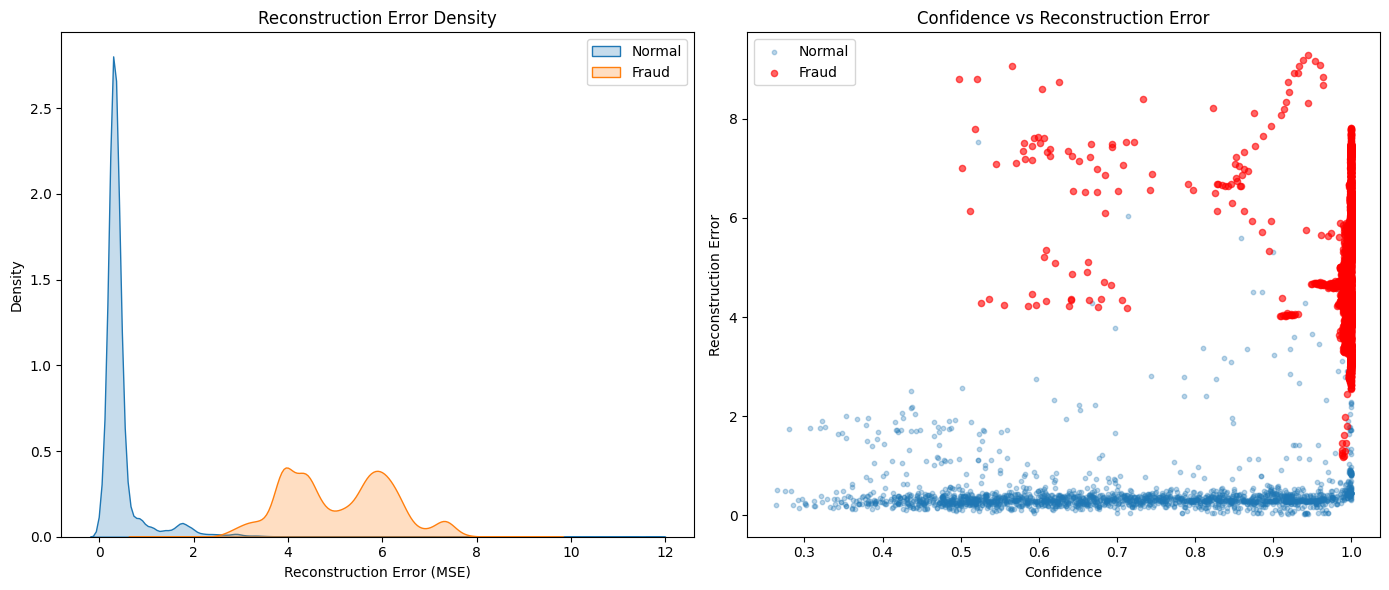

In [8]:
def evaluate_model(model, dataset, device):
    model.eval()
    model.to(device)
    loader = DataLoader(dataset, batch_size=256, shuffle=False)

    recon_errors = []
    labels = []
    confidences = []

    print("Evaluating...")
    with torch.no_grad():
        for batch in loader:
            x = batch["x"].to(device)
            y = batch.get("y")

            # Forward pass with full cognitive loop
            # SamadhiEngine.forward(x, run_vitakka=True, run_vicara=True)
            # Returns: output, s_final, meta
            x_recon, s_final, meta = model(x, run_vitakka=True, run_vicara=True)

            # Calculate MSE per sample
            loss = torch.mean((x_recon - x)**2, dim=[1, 2])

            recon_errors.append(loss.cpu().numpy())
            confidences.append(meta["confidence"].cpu().numpy())
            if y is not None:
                labels.append(y.cpu().numpy())

    return (
        np.concatenate(recon_errors),
        np.concatenate(labels) if labels else None,
        np.concatenate(confidences)
    )

# Run Evaluation
recon_errs, y_true, confs = evaluate_model(model, test_dataset, device)

# --- Metrics ---
roc_score = roc_auc_score(y_true, recon_errs)
print(f"ROC-AUC Score: {roc_score:.4f}")

# Find Best Threshold (F1)
precision, recall, thresholds = precision_recall_curve(y_true, recon_errs)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold (Max F1): {best_threshold:.4f}")

# Classification Report
y_pred = (recon_errs > best_threshold).astype(int)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Fraud"]))

# --- Visualization ---
plt.figure(figsize=(14, 6))

# 1. Error Distribution
plt.subplot(1, 2, 1)
sns.kdeplot(recon_errs[y_true==0], fill=True, label='Normal')
sns.kdeplot(recon_errs[y_true==1], fill=True, label='Fraud')
plt.title('Reconstruction Error Density')
plt.xlabel('Reconstruction Error (MSE)')
plt.legend()

# 2. Scatter Plot (Conf vs Error)
plt.subplot(1, 2, 2)
# Subsample for scatter plot clarity
idx_norm = np.where(y_true==0)[0]
if len(idx_norm) > 2000:
    idx_norm = np.random.choice(idx_norm, 2000, replace=False)
idx_fraud = np.where(y_true==1)[0]

plt.scatter(confs[idx_norm], recon_errs[idx_norm], alpha=0.3, s=10, label='Normal')
plt.scatter(confs[idx_fraud], recon_errs[idx_fraud], alpha=0.6, s=20, color='red', label='Fraud')
plt.title('Confidence vs Reconstruction Error')
plt.xlabel('Confidence')
plt.ylabel('Reconstruction Error')
plt.legend()

plt.tight_layout()
plt.show()
